# 5.2 線形回帰(linear regression()

In [2]:
# パッケージの読み込み
using Distributions, PyPlot, LinearAlgebra

In [3]:
function set_options(ax, xlabel, ylabel, title;
                     grid=true, gridy=false, legend=false)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if grid
        if gridy
            ax.grid(axis="y")
        else
            ax.grid()
        end
    end
    legend && ax.legend()
    return
end

set_options (generic function with 1 method)

## 5.2.1 生成過程

In [4]:
function generate_linear(X, σ, μ₁, μ₂, σ₁, σ₂)
    w₁ = rand(Normal(μ₁, σ₁))
    w₂ = rand(Normal(μ₂, σ₂))
    f(x) = w₁ * x + w₂
    Y = rand.(Normal.(f.(X), σ))
    Y, f, w₁, w₂
end

generate_linear (generic function with 1 method)

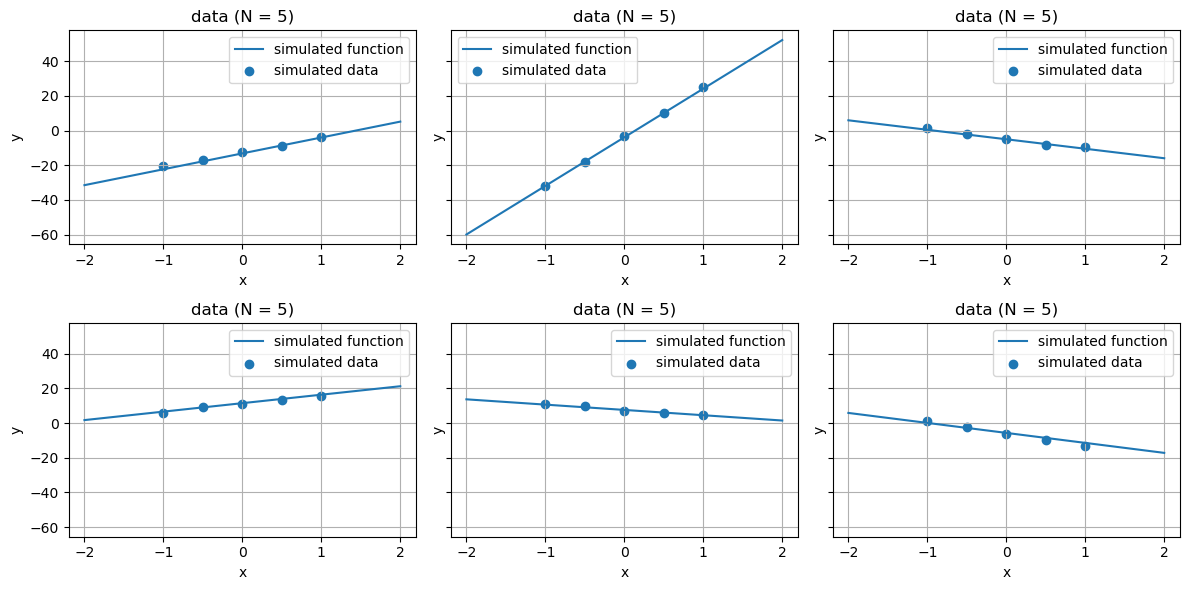

In [5]:
# あらかじめ与えるパラメータと入力集合X
σ = 1.0
μ₁ = 0.0
μ₂ = 0.0
σ₁ = 10.0
σ₂ = 10.0
X = [-1.0, -0.5, 0, 0.5, 1.0]

# 可視化する範囲
xs = range(-2, 2, length=100)

fig, axes = subplots(2, 3, sharey=true, figsize=(12,6))
for ax in axes
    # 関数f, 出力Yの生成
    Y, f, w₁, w₂ = generate_linear(X, σ, μ₁, μ₂, σ₁, σ₂)
    
    # 生成された直線とYのプロット
    ax.plot(xs, f.(xs), label="simulated function")
    ax.scatter(X, Y, label="simulated data")
    
    set_options(ax, "x", "y", "data (N = $(length(X)))", legend=true)
end

tight_layout()

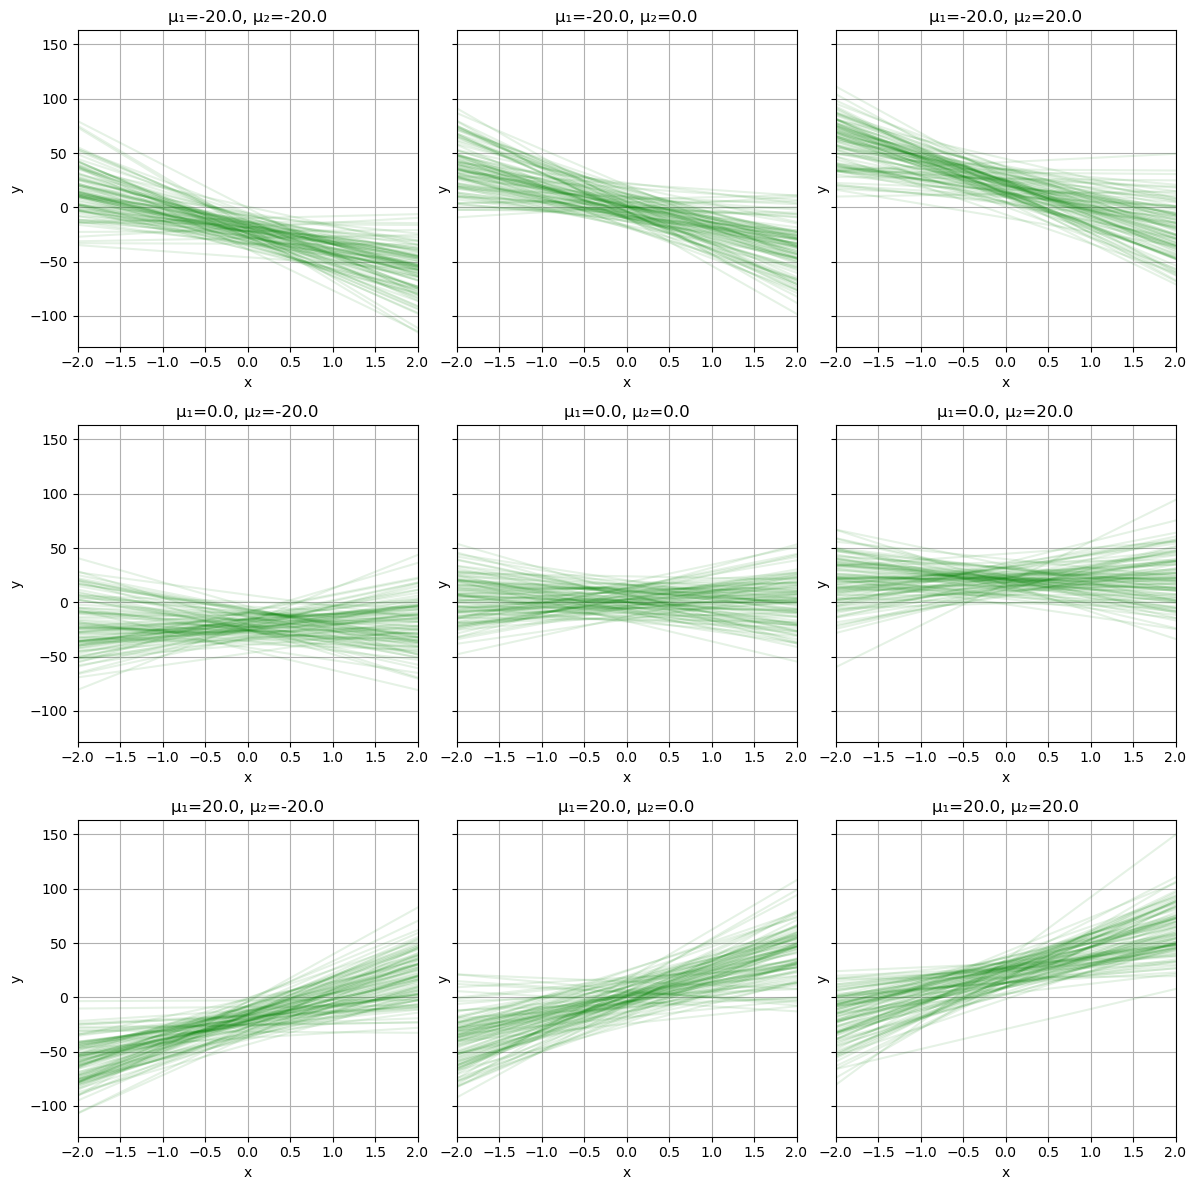

In [6]:
# 平均パラメータのリスト
μ₁_list = [-20.0, 0.0, 20.0]
μ₂_list = [-20.0, 0.0, 20.0]

# 標準偏差パラメータは固定
σ₁ = 10.0
σ₂ = 10.0

fig, axes = subplots(length(μ₁_list), length(μ₂_list), sharey=true, figsize=(12,12))
for (i, μ₁) in enumerate(μ₁_list)
    for (j, μ₂) in enumerate(μ₂_list)
        # 関数を複数サンプル
        fs = [generate_linear(X, σ, μ₁, μ₂, σ₁, σ₂)[2] for _ in 1:100]

        # 生成された直線群のプロット
        for f in fs
            axes[i,j].plot(xs, f.(xs), "g", alpha=0.1)
        end
        
        axes[i,j].set_xlim(extrema(xs))
        set_options(axes[i,j], "x", "y", "μ₁=$(μ₁), μ₂=$(μ₂)")
    end
end

tight_layout()

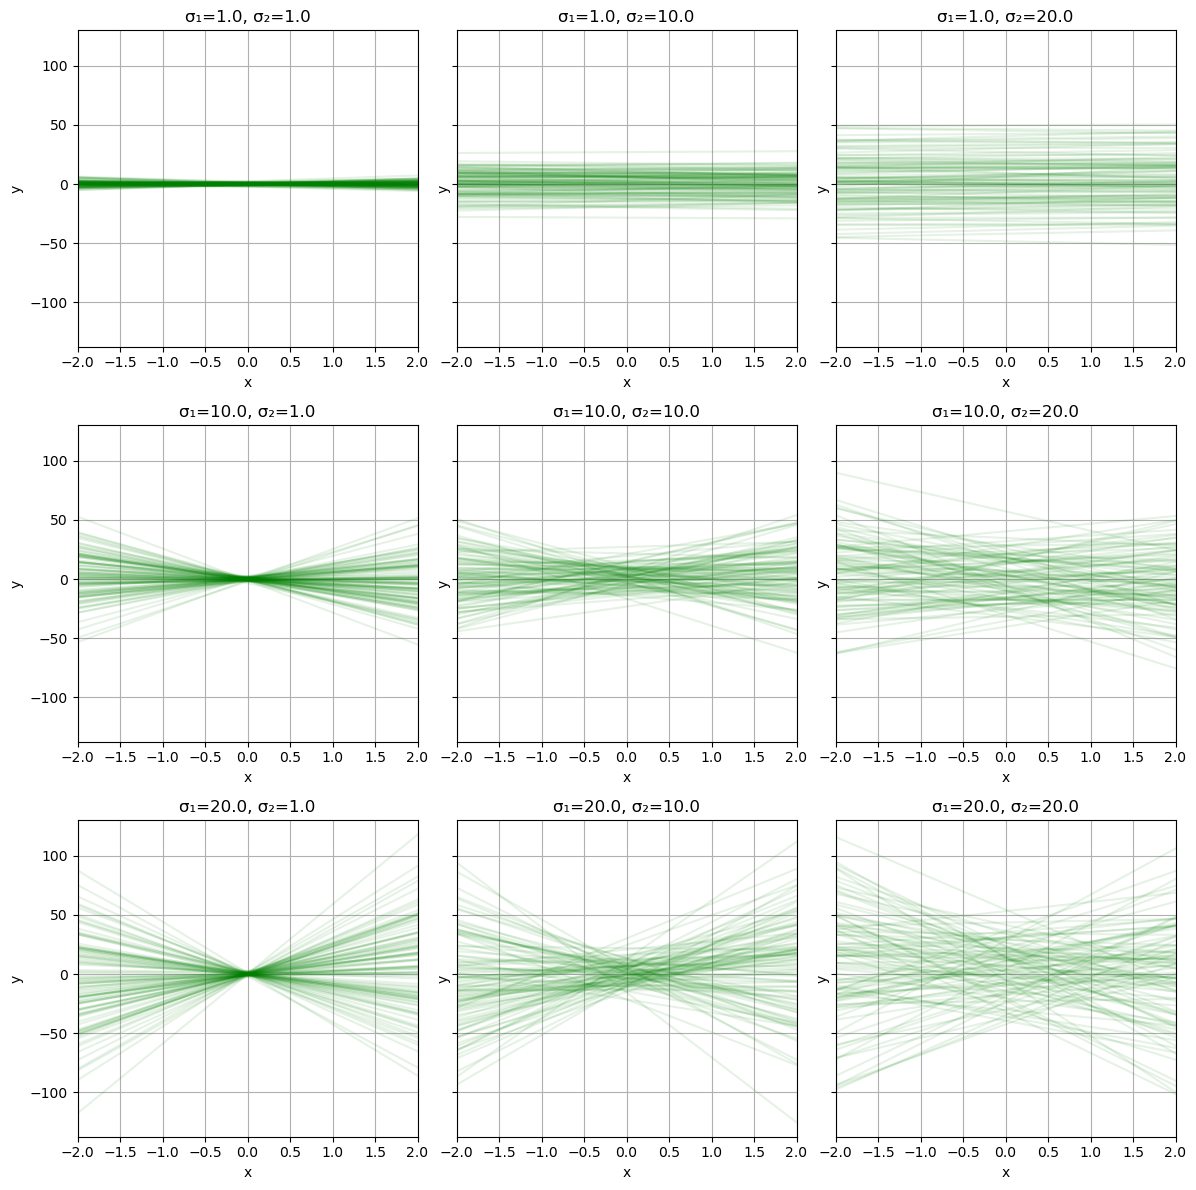

In [7]:
# 標準偏差パラメータのリスト
σ₁_list = [1.0, 10.0, 20.0]
σ₂_list = [1.0, 10.0, 20.0]

# 平均パラメータは固定
μ₁ = 0.0
μ₂ = 0.0

fig, axes = subplots(length(σ₁_list), length(σ₂_list), sharey=true, figsize=(12,12))
for (i, σ₁) in enumerate(σ₁_list)
    for (j, σ₂) in enumerate(σ₂_list)
        # 関数を複数サンプル
        fs = [generate_linear(X, σ, μ₁, μ₂, σ₁, σ₂)[2] for _ in 1:100]

        # 生成された直線群のプロット
        for f in fs
            axes[i,j].plot(xs, f.(xs), "g", alpha=0.1)
        end
        
        axes[i,j].set_xlim(extrema(xs))
        set_options(axes[i,j], "x", "y", "σ₁=$(σ₁), σ₂=$(σ₂)")
    end
end

tight_layout()

## 5.1.5 数値積分

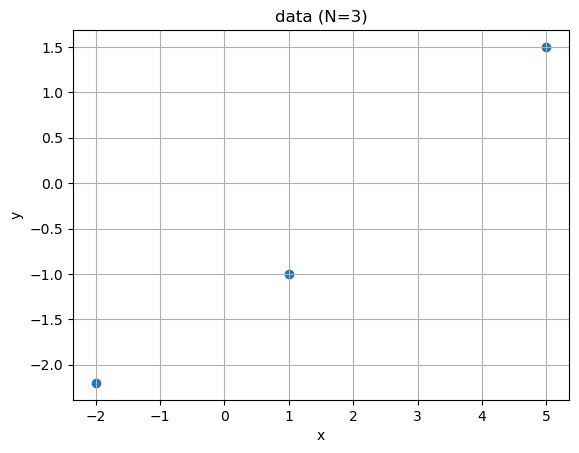

In [8]:
# 入力データセット
X_obs = [-2, 1, 5]

# 出力データセット
Y_obs = [-2.2, -1.0, 1.5]

# 散布図で可視化
fig, ax = subplots()
ax.scatter(X_obs, Y_obs)
set_options(ax, "x", "y", "data (N=$(length(X_obs)))")

In [9]:
# 同時分布
p_joint(X, Y, w₁, w₂) = prod(pdf.(Normal.(w₁.*X .+ w₂, σ), Y)) * pdf(Normal(μ₁, σ₁), w₁) * pdf(Normal(μ₂, σ₂), w₂)

# 数値積分
function approx_integration_2D(w_range, p)
    Δ = w_range[2] - w_range[1]
    (X, Y) -> sum([p(X, Y, w₁, w₂) * Δ^2 for w₁ in w_range, w₂ in w_range])
end

# wの積分範囲
w_range = range(-3, 3, length=100)

# 数値積分の実行
p_marginal = approx_integration_2D(w_range, p_joint)
p_marginal(X_obs, Y_obs)

6.924264340150274e-5

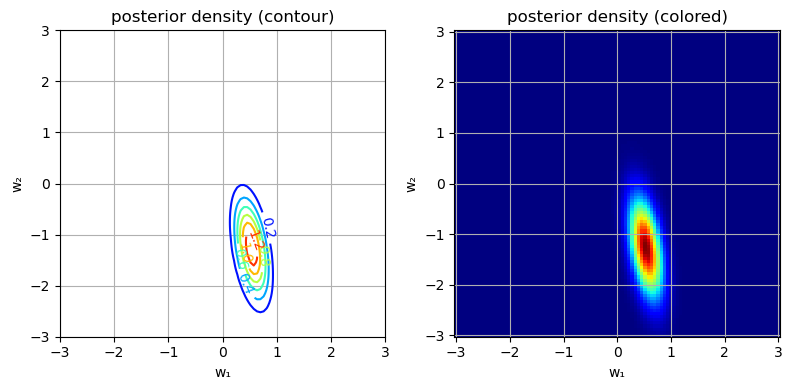

In [10]:
# 事後分布の計算
w_posterior = [p_joint(X_obs, Y_obs, w₁, w₂) for w₁ in w_range, w₂ in w_range] ./ p_marginal(X_obs, Y_obs)

fig, axes = subplots(1, 2, figsize=(8,4))

# 等高線図
cs = axes[1].contour(w_range, w_range, w_posterior', cmap="jet")
axes[1].clabel(cs, inline=true)
set_options(axes[1], "w₁", "w₂", "posterior density (contour)")

# カラーメッシュ
xgrid = repeat(w_range', length(w_range), 1)
ygrid = repeat(w_range, 1, length(w_range))
axes[2].pcolormesh(xgrid, ygrid, w_posterior', cmap="jet", shading="auto")
set_options(axes[2], "w₁", "w₂", "posterior density (colored)")

tight_layout()

In [11]:
function approx_predictive(w_posterior, w_range, p)
    Δ = w_range[2] - w_range[1]
    (x, y) -> sum([p(x, y, w₁, w₂) * w_posterior[i,j] * Δ^2 
                for (i,w₁) in enumerate(w_range), 
                    (j,w₂) in enumerate(w_range)])
end
p_likelihood(xₚ, yₚ, w₁, w₂) = pdf(Normal(w₁*xₚ + w₂, σ), yₚ)
p_predictive = approx_predictive(w_posterior, w_range, p_likelihood)

#13 (generic function with 1 method)

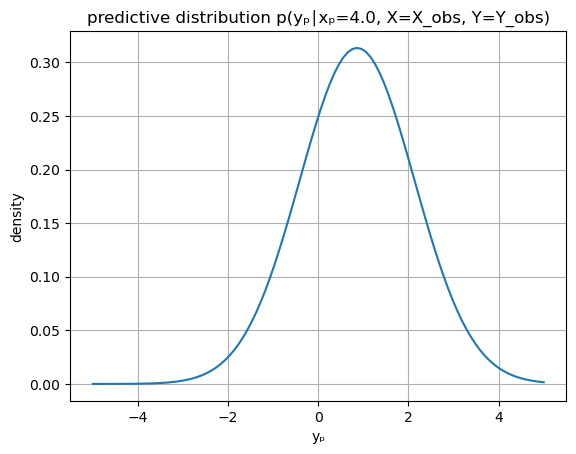

In [12]:
xₚ = 4.0
fig, ax = subplots()
ys = range(-5, 5, length=100)
ax.plot(ys, p_predictive.(xₚ, ys))
set_options(ax, "yₚ", "density", "predictive distribution p(yₚ∣xₚ=$(xₚ), X=X_obs, Y=Y_obs)")

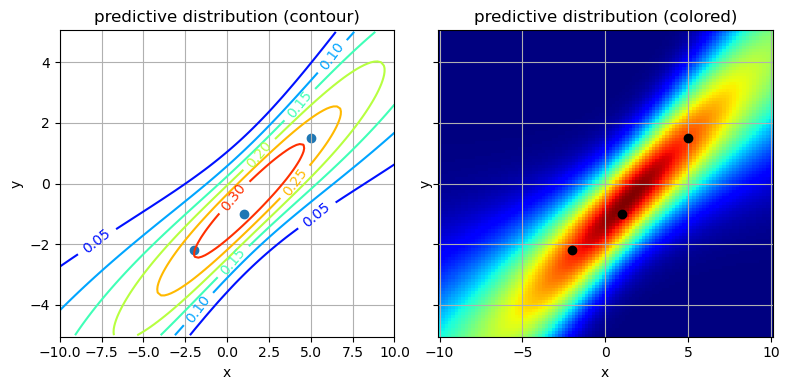

In [13]:
# 描画範囲
xs = range(-10, 10, length=100)
ys = range(-5, 5, length=100)

# 密度の計算
density_y = p_predictive.(xs, ys')

fig, axes = subplots(1, 2, sharey=true, figsize=(8,4))

# 等高線図
cs = axes[1].contour(xs, ys, density_y', cmap="jet")
axes[1].clabel(cs, inline=true)
axes[1].scatter(X_obs, Y_obs)
set_options(axes[1], "x", "y", "predictive distribution (contour)")

# カラーメッシュ
xgrid = repeat(xs', length(ys), 1)
ygrid = repeat(ys, 1, length(xs))
axes[2].pcolormesh(xgrid, ygrid, density_y', cmap="jet", shading="auto")
axes[2].plot(X_obs, Y_obs, "ko", label="data")
set_options(axes[2], "x", "y", "predictive distribution (colored)")

tight_layout()

## 5.1.6 厳密解法

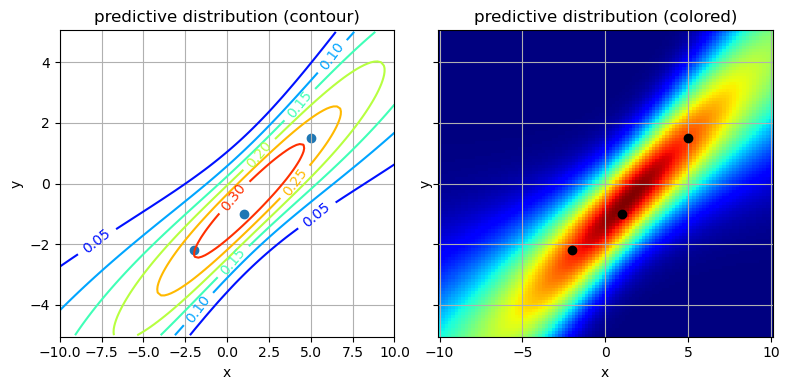

In [14]:
# 切片用の擬似データ
X_extended = hcat(X_obs, ones(size(X_obs)))'

# 事前分布のパラメータ
Σ = [σ₁^2 0;
     0 σ₂^2]
μ = [μ₁, μ₂]

# 事後分布のパラメータ
Σ_hat = inv(σ^(-2) * X_extended * X_extended' + inv(Σ))
μ_hat = Σ_hat * (σ^(-2) * X_extended * Y_obs + inv(Σ)*μ)

# 予測分布のパラメータ
μₚ(Xₚ) = (μ_hat' * xₚ)[1]
σₚ(Xₚ) = sqrt(σ^2 + (xₚ' * Σ_hat * xₚ)[1])

# 予測分布の確率密度関数
p_predictive_exact(xₚ, yₚ) = pdf(Normal(μₚ(xₚ), σₚ(xₚ)), yₚ)

# 描画範囲
xs = range(-10, 10, length=100)
ys = range(-5, 5, length=100)
density_y = [p_predictive_exact([x, 1.0], y) for x in xs, y in ys]

# 密度の計算
density_y = p_predictive.(xs, ys')

fig, axes = subplots(1, 2, sharey=true, figsize=(8,4))

# 等高線図
cs = axes[1].contour(xs, ys, density_y', cmap="jet")
axes[1].clabel(cs, inline=true)
axes[1].scatter(X_obs, Y_obs)
set_options(axes[1], "x", "y", "predictive distribution (contour)")

# カラーメッシュ
xgrid = repeat(xs', length(ys), 1)
ygrid = repeat(ys, 1, length(xs))
axes[2].pcolormesh(xgrid, ygrid, density_y', cmap="jet", shading="auto")
axes[2].plot(X_obs, Y_obs, "ko", label="data")
set_options(axes[2], "x", "y", "predictive distribution (colored)")

tight_layout()